# Import Libraries/Packages & Datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import copy

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(5703)
torch.manual_seed(5703)
np.random.seed(5703)
random.seed(5703)

## Set Working directory
## Load benign data, drop unwanted columns
 

In [2]:
fulldata = pd.read_csv('idsdata\CICIDS_ALLATTACKS.csv')
fulldata['Label'].value_counts()

Label
Benign                      4263051
DoS attacks-Hulk             439126
DDOS attack-HOIC             360833
Bot                          285763
FTP-BruteForce               193354
SSH-Bruteforce               187589
Infilteration                152874
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         39924
DoS attacks-Slowloris          2724
DDOS attack-LOIC-UDP           1730
Attack                          544
Name: count, dtype: int64

In [3]:
fulldata['Label'].replace('Attack', 'Brute Force -XSS', inplace=True)
fulldata['Label'].value_counts()

Label
Benign                      4263051
DoS attacks-Hulk             439126
DDOS attack-HOIC             360833
Bot                          285763
FTP-BruteForce               193354
SSH-Bruteforce               187589
Infilteration                152874
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         39924
DoS attacks-Slowloris          2724
DDOS attack-LOIC-UDP           1730
Brute Force -XSS                544
Name: count, dtype: int64

In [4]:
train_datas = {}
test_datas = {}
mixed_data = pd.DataFrame()
for i in fulldata['Label'].unique():
    if fulldata[fulldata['Label'] == i].shape[0] > 100000:
        print(i)
        train_datas[i] = fulldata[fulldata['Label'] == i][:100000]
        test_datas[i] = fulldata[fulldata['Label'] == i][100000:110000]
        mixed_data = pd.concat([mixed_data, fulldata[fulldata['Label'] == i][110000:120000]], axis=0)

Benign
Bot
DDOS attack-HOIC
DoS attacks-Hulk
DoS attacks-SlowHTTPTest
FTP-BruteForce
Infilteration
SSH-Bruteforce


In [5]:
del fulldata

In [6]:
mixed_data = mixed_data.sample(frac=1).reset_index(drop=True)
mixed_data_labels = list(mixed_data['Label'])
mixed_data.drop(['Label'], axis=1, inplace=True)
mixed_data = mixed_data.to_numpy()
for i in train_datas:
    train_datas[i].drop(['Label'], axis=1, inplace=True)
    test_datas[i].drop(['Label'], axis=1, inplace=True)
    train_datas[i] = train_datas[i].sample(frac=1).reset_index(drop=True)
    test_datas[i] = test_datas[i].sample(frac=1).reset_index(drop=True)
    train_datas[i] = train_datas[i].to_numpy()
    test_datas[i] = test_datas[i].to_numpy()

In [7]:
#loading data into pytorch dataloader as train and test
devices = []
batch_size = 128
train_loader = {}
for i in train_datas:
  train_loader[i] = torch.utils.data.DataLoader(train_datas[i], batch_size = batch_size, shuffle=True)
  devices.append(i)

In [8]:
len(train_loader)

8

In [9]:
len(devices)

8

In [10]:
#initialising config variables
num_clients = len(train_loader)      # Number of clients
num_selected = len(train_loader)    # Typically, num_selected is around 30–40% of the num_clients.
#baseline_num = 1000  # choose some data from the train set to retrain the data from trained model
num_rounds = 5  #100      # Total number of communication rounds for the global model to train.
epochs = 50          # for train client model
#retrain_epochs = 3  # Total number of retraining rounds on the global server after receiving the model weights
                      # from all the clients that participated in the communication round.

## FedAvg / FedAvgM

In [11]:
# aggregates the model weights received from every client
# and updates the global model with updated weights

# FedAvg
def server_aggregate(global_model, client_models, client_lens):
    total = sum(client_lens)
    n = len(client_models)
    # n = num_selected
    global_dict = global_model.state_dict()
    for k in global_dict.keys(): # calculate average weight/bias --> avg_w/b
        global_dict[k] -= torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    #for model in client_models:
     #   model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias

# FedAvgM
def server_aggregate_M(global_model, client_models, client_lens):
    total = sum(client_lens)    # 592    sum [51, 122, 162, 257]
    n = len(client_models)      # 4 local clients
    global_dict = global_model.state_dict() # weight/bias dict --> {'encoder.0.weight': Tensor with shape torch.Size([86, 115]), 'encoder.0.bias':....} 16 items
    temp = copy.deepcopy(global_dict)       # temporary weight/bias dict
    v = {x:1 for x in copy.deepcopy(global_dict)}   # initialise v

    for i,k in enumerate(global_dict.keys()):
        # calculate average weight/bias --> avg_w/b
        temp[k] = torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
        temp_v = 0.9 * v[k] + temp[k]               # v = 0.9v + avg_w/b   momentum=0.9
        global_dict[k] = global_dict[k] - temp_v    # w = w - v
    global_model.load_state_dict(global_dict)

    #for model in client_models:
     #   model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias



In [12]:
# for updates/trains client model on client data
# local training round that takes place for every selected client

def client_update(client_model, optimizer, train_data, epoch=3):
    client_model.train()
    for e in range(epoch):
        running_loss = 0.0
        for data in train_data:
          output = client_model(data.float()) # tensor 115
          optimizer.zero_grad()
          # criterion = nn.MSELoss(reduction='mean')
          # loss = criterion(data.to(device), output)
          loss = nn.MSELoss(reduction='mean')(data.float().to(device), output)
          loss.backward()
          optimizer.step()
          # print(loss.item())
          running_loss += loss.item()
        # print(running_loss)
        epoch_loss = running_loss/len(train_data)
        # metrics['train_loss'].append(epoch_loss)
    return epoch_loss
    # return loss.item()



# synchronizes the client model with global weights (before training)

def client_syn(client_model, global_model):
    client_model.load_state_dict(global_model.state_dict())

## Deep Auto-encoder Model

In [13]:
import torch.nn as nn

input_dim = train_loader['Benign'].dataset.shape[1]

class AEModel(nn.Module):
    def __init__(self, input_dim):
        super(AEModel, self).__init__()
        
        xavier_gain = nn.init.calculate_gain('tanh')
        
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 32)  
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 8)
        self.fc6 = nn.Linear(8, 16)
        self.fc7 = nn.Linear(16, 32)
        self.fc8 = nn.Linear(32, input_dim)
        self.fc9 = nn.Linear(input_dim, input_dim)
       
        self.activation = nn.Tanh()
        
        nn.init.xavier_uniform_(self.fc1.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc2.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc3.weight, gain=xavier_gain) 
        nn.init.xavier_uniform_(self.fc4.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc5.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc6.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc7.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc8.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc9.weight, gain=xavier_gain)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x) 
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x) 
        x = self.fc6(x)
        x = self.activation(x)
        x = self.fc7(x)
        x = self.activation(x)
        x = self.fc8(x) 
        x = self.activation(x)
        x = self.fc9(x)
        return x

## Initialisation

In [14]:
# Initializing models and optimizer

global_model = AEModel(input_dim).to(device)
client_models = [AEModel(input_dim).to(device) for _ in range(num_selected)] # part or all clients
# print(client_models)
for model in client_models:
    model.load_state_dict(global_model.state_dict())

# method_env = {'lr': (0.012, 0.012, 0.012, 0.0005)}
#opt = [torch.optim.SGD(model.parameters(), lr = 0.012, weight_decay=1e-05, momentum=0.9) for model in client_models]
# lr_list = [0.012, 0.012, 0.012, 0.00005]
# # opt = [torch.optim.SGD(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05, momentum=0.9) for model in client_models]
# opt = [torch.optim.Adam(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05) for model in client_models]
opt = [torch.optim.Adam(model.parameters(), lr = 0.012, weight_decay=1e-05) for model in client_models]

# Training Federated Model

In [15]:
# Train Client Model and Global Model
train_loss_client = []
train_loss_global = []
train_loss_per_client = [[] for i in range(num_clients)]
train_loss_benign = []

start_time = time.time()

for r in range(num_rounds): # total number of rounds

    print('\nround: ', r+1)
    # num_selected = random.choice(range(1,num_clients))
    #client_idx = np.random.permutation(num_clients)[:num_selected] # random pick some clients from all clients for train
    client_idx = list(range(num_clients))
    print('client_idx: ', client_idx)
    client_lens = [len(train_loader[devices[idx]]) for idx in client_idx ] # Need to fix this. It is part of server aggregation.
    # client_lens = [len(train_lotrain_loaderader[idx]) for idx in client_idx ]
    #print(client_lens)


    #### client update ####
    loss = 0
    for i in tqdm(range(num_selected)):
        # print(i)
        #client_syn(client_models[i], global_model)
        # print(train_loader[devices[client_idx[i]]])
        if devices[client_idx[i]] != 'Benign':
            l = client_update(client_models[i], opt[i], train_loader[devices[client_idx[i]]], epochs)
            train_loss_per_client[i].append(l)
            loss += l
    train_loss_client.append(loss)

    #### benign client update ####
    for i in tqdm(range(1)):
        l = client_update(client_models[-1], opt[-1], train_loader['Benign'], epochs)
        train_loss_benign.append(l)
    train_loss_per_client[-1] = train_loss_benign
    train_loss_client.append(sum(train_loss_benign))


    #### retraining on the global server ####
    #loss_retrain = 0
    #for i in tqdm(range(num_selected)):
    #    loss_retrain += client_update(client_models[i], opt[i], baseline_data[devices[client_idx[i]]], retrain_epochs)
    #train_loss_global.append(loss_retrain/num_selected)

    attackclients = []
    for i in devices:
        if i != 'Benign':
            attackclients.append(client_models[devices.index(i)])
    
    ### aggregate models ###
    server_aggregate(global_model, attackclients, client_lens)      # FedAvg
    #server_aggregate_M(global_model, attackclients, client_lens)    # FedAvgM

    print("\nclient_loss: ", loss)
    #print('global_loss: ', loss_retrain/num_selected)

time_required = time.time() - start_time
print('/nTIME: {}mins'.format(time_required/60))


round:  1
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7]


100%|██████████| 1/1 [01:44<00:00, 104.02s/it]



client_loss:  0.03624726956477423

round:  2
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7]


100%|██████████| 1/1 [01:43<00:00, 103.52s/it]



client_loss:  0.049644224482336796

round:  3
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7]


100%|██████████| 1/1 [01:43<00:00, 103.85s/it]



client_loss:  0.001369323949458815

round:  4
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7]


100%|██████████| 1/1 [01:48<00:00, 108.00s/it]



client_loss:  0.019908413710127183

round:  5
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7]


100%|██████████| 1/1 [01:44<00:00, 104.96s/it]


client_loss:  0.008767264726083272
/nTIME: 80.96822998523712mins


In [16]:
for i in range(len(train_loss_per_client)):
  print(train_loss_per_client[i])

[]
[0.0001952327496694771, 6.838098246312849e-05, 8.105095154692986e-05, 0.011557985869422176, 7.30654146397271e-05]
[1.433580044370494e-05, 0.018493841281946737, 1.1874735338280559e-05, 9.375400576435917e-05, 9.139977829849638e-05]
[0.0011940125118517686, 0.00014752008059299918, 0.00015560413449024603, 0.0038336050744160123, 0.00022730533019615733]
[1.610234300370182e-05, 0.00114665924713773, 1.9394008303376542e-05, 1.9770245246008298e-05, 0.00012988324962740996]
[0.0037220911021032333, 2.7224052260267188e-05, 4.576088689450595e-05, 0.0034922509894246604, 2.586446767880196e-05]
[0.030941080904620534, 0.02954546518254188, 0.0008907179691908581, 0.0007486898493950072, 0.008172634204782907]
[0.004892855228217857, 0.00021513365539405056, 0.008733569063803615, 0.0001649212636946179, 0.009444880695856365, 0.00016235767645895948, 0.0018697763362791047, 4.711228085977226e-05, 0.009667745874742109]


In [17]:
# save model
torch.save(global_model,'C:/Final Year Project/models/globalattackmodel.pt')

In [18]:
for i in range(len(devices)):
  torch.save(client_models[i],'C:/Final Year Project/models/clients/' + devices[i] + '.pt')

In [19]:
losspic = 1
def printperformance(losses, modelname):
    global losspic
    plt.plot(losses)
    plt.xlabel('number of rounds')
    plt.ylabel('loss')
    plt.ylim((0, 2.5))
    plt.grid()
    plt.title(modelname)
    plt.show()
    plt.savefig("C:/Final Year Project/images/" + str(modelname) + str(losspic) + ".png")
    losspic += 1

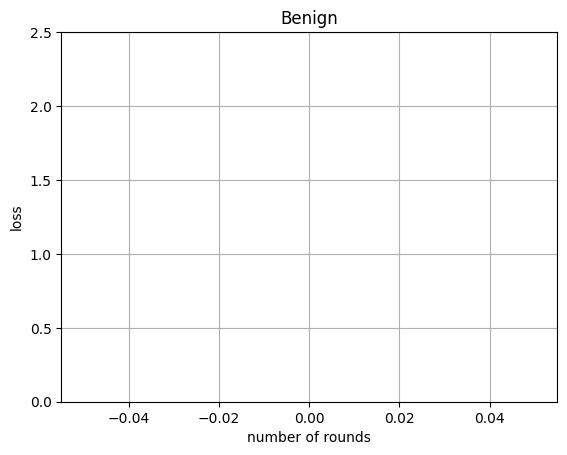

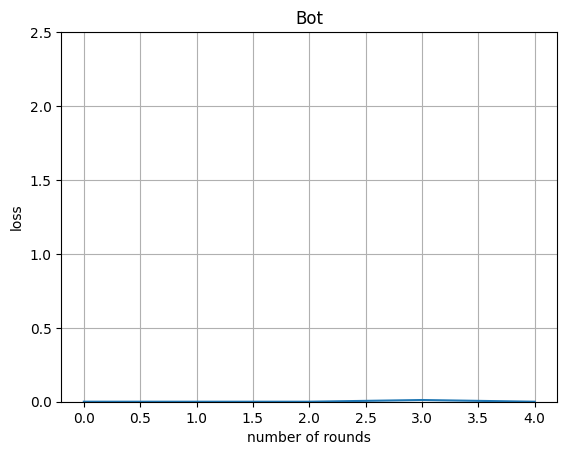

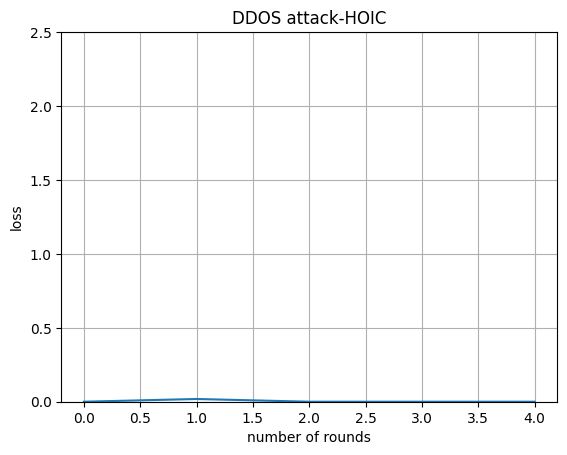

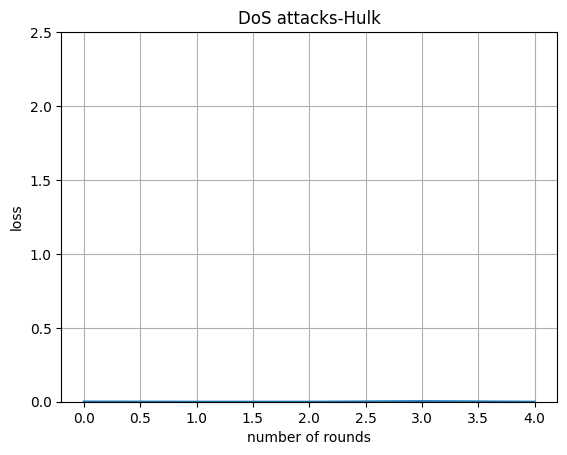

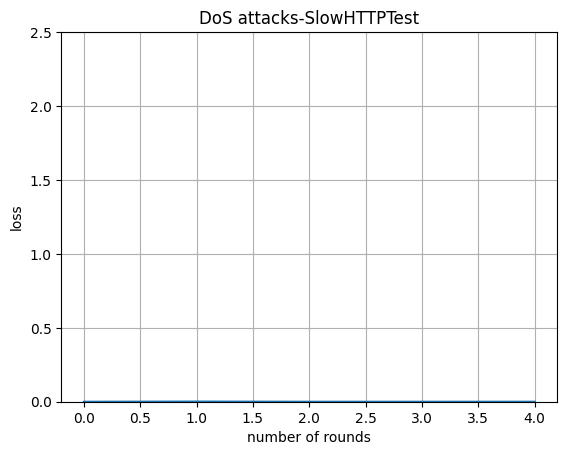

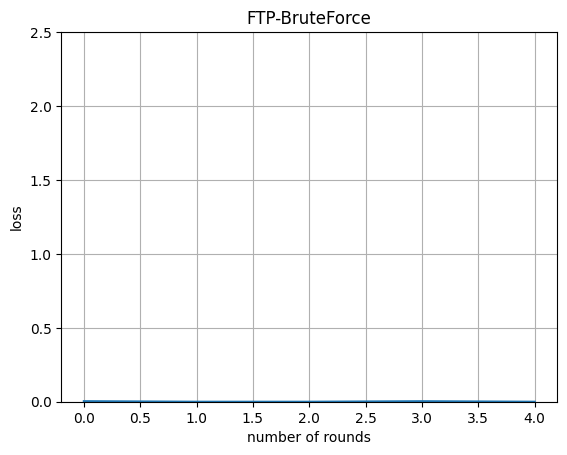

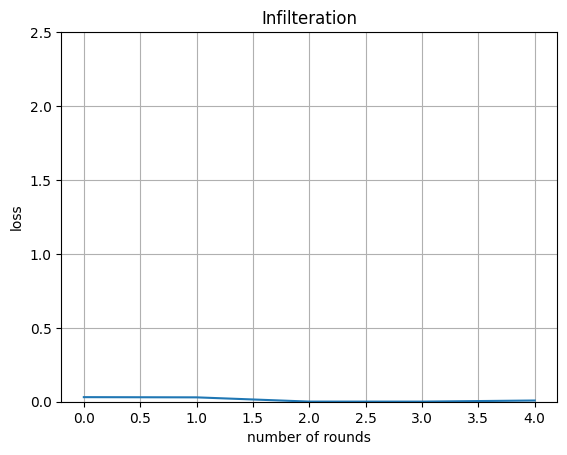

<Figure size 640x480 with 0 Axes>

In [20]:
for i in range(len(devices)-1):
  printperformance(train_loss_per_client[i], devices[i])

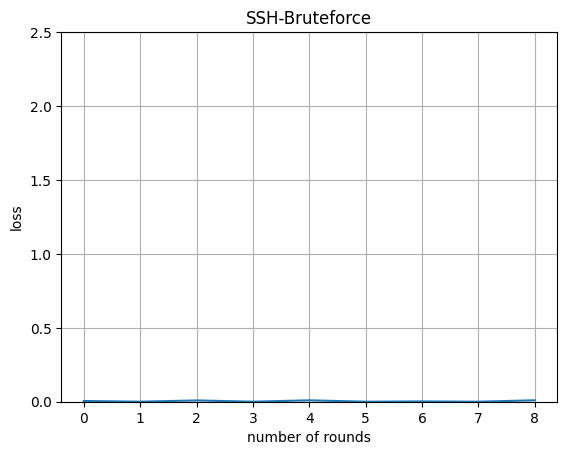

<Figure size 640x480 with 0 Axes>

In [21]:
# print performance of benign client
printperformance(train_loss_benign, devices[-1])

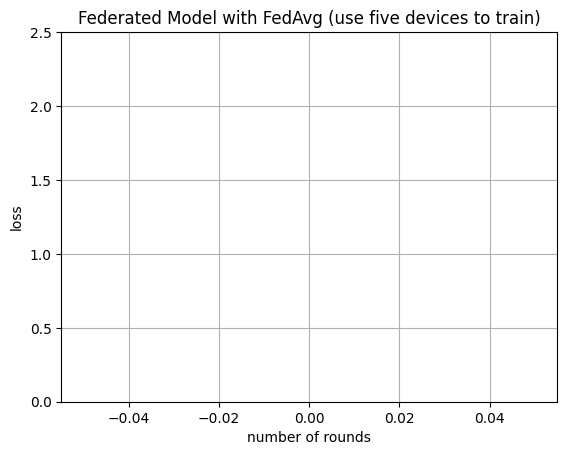

<Figure size 640x480 with 0 Axes>

In [22]:
# train_loss_global
plt.plot(train_loss_global)
plt.xlabel('number of rounds')
plt.ylabel('loss')
plt.ylim((0, 2.5))
plt.grid()
plt.title('Federated Model with FedAvg (use five devices to train)')
plt.show()
plt.savefig("C:/Final Year Project/images/Global10.png")

# Evaluation

In [79]:
client_models = {}
for device in devices:
  client_models[device] = torch.load('C:/Final Year Project/models/clients/' + device + '.pt')

In [80]:
from sklearn import metrics

In [81]:
def get_thresh(model, dataloader):

    model.eval()
    errs = []
    mses = []
    for batch in dataloader:
       for data in batch:
         mse = np.power(data.float().cpu().detach().numpy() - model(data.float()).cpu().detach().numpy(), 2) #before np.mean(..., axis=0) (len(mse) = 56)
         mses.append(mse)
    mses = np.array(mses)
    print("MSES: " + str(mses.shape))
    thresh = mses.mean(axis=0) + mses.std(axis=0)
    print(thresh.shape)
    #errs.append(thresh)
    #thresh = sum(errs) / len(errs)
    return thresh

    #model.eval()
    #pred = global_model(tr_data).cpu().detach().numpy()
    #print(pred)
    #print(np.isnan(pred))
    #thresh = np.sqrt(metrics.mean_squared_error(pred, threshben.numpy()))
    #mse = np.mean(np.power(tr_data.cpu().detach().numpy() - model(tr_data).cpu().detach().numpy(), 2), axis=1)
    #tr = np.sqrt(metrics.mean_squared_error(model(tr_data).cpu().detach().numpy(), tr_data.cpu().detach().numpy()))
    #tr = np.sqrt(mse)
    #return thresh

    
def quan_thresh(model, dataloader, quantile=0.9):

  model.eval()
  errs = []
  se = []
  
  for batch in dataloader:
    
    for data in batch:
      error = np.power(data.float().cpu().numpy() - model(data.float()).cpu().detach().numpy(), 2) # len(error) = 66
      se.append(sum(error))
    # Calculate threshold as quantile of errors 
    #thresh = np.quantile(se, quantile, axis=0) #before it was thresh = np.quantile(mse, quantile)
    #errs.append(thresh)
  #thresh = np.quantile(mse, quantile)
  return np.mean(se) + np.std(se), np.quantile(se, quantile), se #before it was np.mean(errs)
  #return thresh

def quan_recon(model, dataloader, quantile=0.8):
  model.eval()
  datas = []
  for batch in dataloader:
    for data in batch:
      datas.append(model(data.float()).cpu().detach().numpy())
  thresh = np.quantile(datas, quantile, axis=0)
  return thresh

def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_pred)):
        if y_actual[i] == y_pred[i] == 1:
           TP += 1
        if y_pred[i] == 1 and y_actual[i] != y_pred[i]:
           FP += 1
        if y_actual[i] == y_pred[i] == 0:
           TN += 1
        if y_pred[i] == 0 and y_actual[i] != y_pred[i]:
           FN += 1
    return (TP, FP, TN, FN)

def get_mix_result(model, tr, mix_data, mix_label):
    model.eval()
    prediction = []
    for i in mix_data:
      pred = model(i).cpu().detach().numpy()
      error = np.sqrt(metrics.mean_squared_error(pred, threshben.numpy()))
      if error > tr:
        prediction.append(1)
      else:
        prediction.append(0)

    mix_label_list = mix_label.tolist()

    TP,FP,TN,FN = perf_measure(mix_label_list, prediction)

    conf = [[TP, FN],[FP, TN]]
    print(conf)
    x_axis_label = ['abnormal', 'benign']
    y_axis_label = ['abnormal', 'benign']

    plt.figure()
    sns.heatmap(conf,xticklabels=x_axis_label, yticklabels=y_axis_label, annot=True,annot_kws={"size": 16},fmt='g')

    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1score = 2 * ((precision * recall) / (precision + recall))

    TPR = round((TP / (TP+FN)), 6)
    # print('TPR is: {}%'.format(TPR))

    FPR = round((FP / (FP + TN)), 6)
    # print('TPR is: {}%'.format(FPR))

    print('Acc: %.3f%% \nPrecision: %.3f \nRecall: %.3f \nF1score: %.3f \nTPR: %.5f \nFPR: %.5f'%(acc*100,
                                                                                                   precision,
                                                                                                   recall,
                                                                                                   F1score*100,
                                                                                                   TPR,
                                                                                                   FPR))

#   [['TP', 'FN']
#   ['FP', 'TN']]

In [82]:
thresholds = {}
quans = {}
errors = {}
for device in devices:
    model = client_models[device]
    dataloader = train_loader[device]
    thresholds[device], quans[device], errors[device] = quan_thresh(model, dataloader)
    #thresholds[devices[i]] = quan_recon(model, dataloader)
print(thresholds)

{'Benign': 61.877983871320275, 'Bot': 0.09161945656969751, 'DDOS attack-HOIC': 0.02585825799928147, 'DoS attacks-Hulk': 0.13915533441081115, 'DoS attacks-SlowHTTPTest': 0.007261200969461876, 'FTP-BruteForce': 0.0034343920695094742, 'Infilteration': 0.8323591285998359, 'SSH-Bruteforce': 2.8281726392384128}


In [83]:
quans

{'Benign': 64.72340163750924,
 'Bot': 0.003308025461071363,
 'DDOS attack-HOIC': 0.017486936191330137,
 'DoS attacks-Hulk': 0.02915148835843371,
 'DoS attacks-SlowHTTPTest': 0.006743229271251039,
 'FTP-BruteForce': 0.0041084313850704365,
 'Infilteration': 0.7539601435598133,
 'SSH-Bruteforce': 3.11042413445781}

In [27]:
#@thresholds = {'Benign': 61.877983871320254, 'Bot': 0.09083680293611163, 'DDOS attack-HOIC': 1.8556977635303178, 'DoS attacks-Hulk': 0.11400531390823192, 'DoS attacks-SlowHTTPTest': 0.21217828694483437, 'FTP-BruteForce': 0.0029948042571023934, 'Infilteration': 3.799426671646207, 'SSH-Bruteforce': 1.0148292389310203}
# mean + std of sse for 2 round 50 epoch

In [35]:
thresholds={'Benign': 61.87798387132028, 'Bot': 0.09161945656969754, 'DDOS attack-HOIC': 0.025858257999281466, 'DoS attacks-Hulk': 0.13915533441081115, 'DoS attacks-SlowHTTPTest': 0.007261200969461876, 'FTP-BruteForce': 0.0034343920695094742, 'Infilteration': 0.832359128599836, 'SSH-Bruteforce': 2.8281726392384123}
# 5 round 50 epoch

In [28]:
len(thresholds)

8

In [29]:
devices

['Benign',
 'Bot',
 'DDOS attack-HOIC',
 'DoS attacks-Hulk',
 'DoS attacks-SlowHTTPTest',
 'FTP-BruteForce',
 'Infilteration',
 'SSH-Bruteforce']

In [84]:
c = lambda lst, x: len([y for y in lst if y < x])
for i in devices:
    print(c(errors[i], quans[i]))

90000
90000
90000
90000
89996
89997
90000
90000


In [88]:
for i in devices:
    print(c(errors[i], thresholds[i]))

85105
99745
96176
97693
96022
81363
91739
73575


In [85]:
def quan_thresh_test(model, testset, quantile=0.9):
    model.eval()
    se = []
    for data in testset:
        data = torch.Tensor(data)
        error = np.power(data.float().cpu().numpy() - model(data.float()).cpu().detach().numpy(), 2) # len(error) = 66
        se.append(sum(error))
    return np.mean(se) + np.std(se), np.quantile(se, quantile), se

In [87]:
thresholds_test = {}
quans_test = {}
errors_test = {}
for device in devices:
    model = client_models[i]
    testset = test_datas[device]
    thresholds_test[device], quans_test[device], errors_test[device] = quan_thresh_test(model, testset)
print(thresholds_test)

{'Benign': 1.402346176448566, 'Bot': 2.4979358903185336, 'DDOS attack-HOIC': 2.033945100778003, 'DoS attacks-Hulk': 2.165225199779038, 'DoS attacks-SlowHTTPTest': 1.9131193304304825, 'FTP-BruteForce': 2.6455494074757695, 'Infilteration': 2.3023770084890063, 'SSH-Bruteforce': 2.811689371872882}


In [93]:
for i in devices:
    print(i, c(errors_test[i], thresholds[i]))

Benign 10000
Bot 0
DDOS attack-HOIC 0
DoS attacks-Hulk 0
DoS attacks-SlowHTTPTest 0
FTP-BruteForce 0
Infilteration 6191
SSH-Bruteforce 7410


In [90]:
for i in devices:
    print(c(errors_test[i], quans[i]))

10000
0
0
0
0
0
6152
9059


### What the model is supposed to find = 1 (Error < Threshold)
### What the model is not supposed to find = 0 (Error > Threshold)

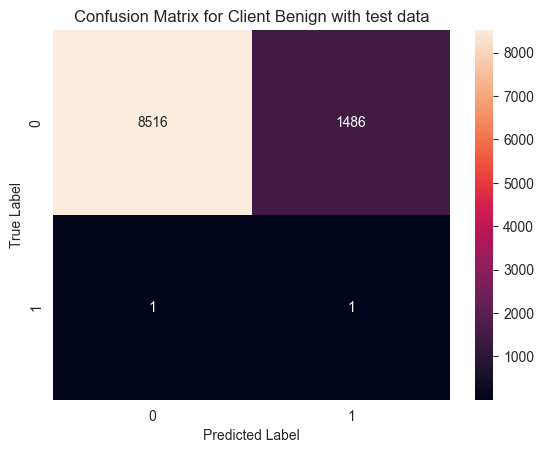

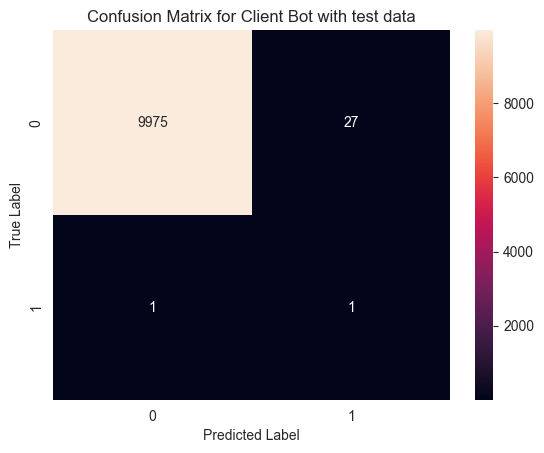

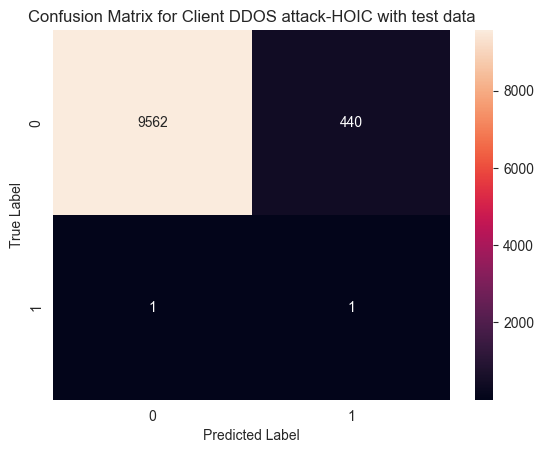

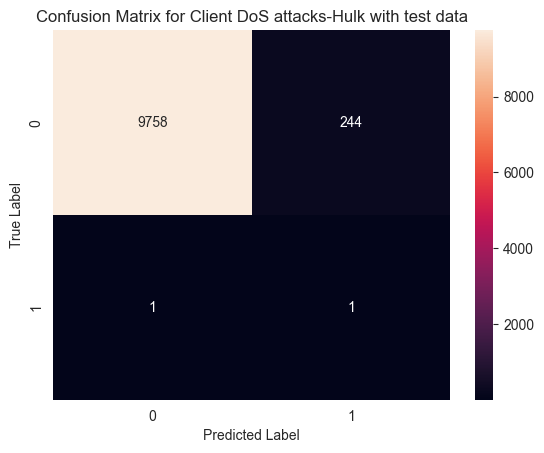

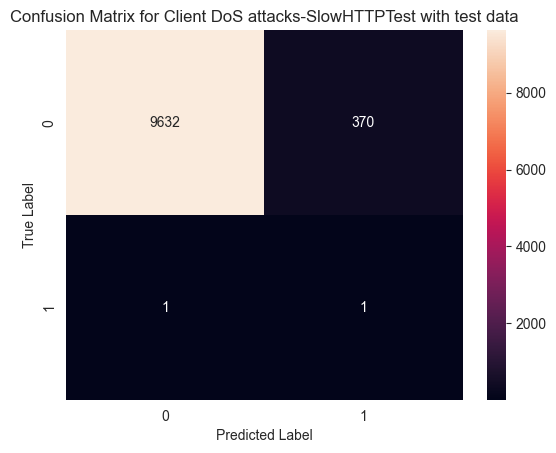

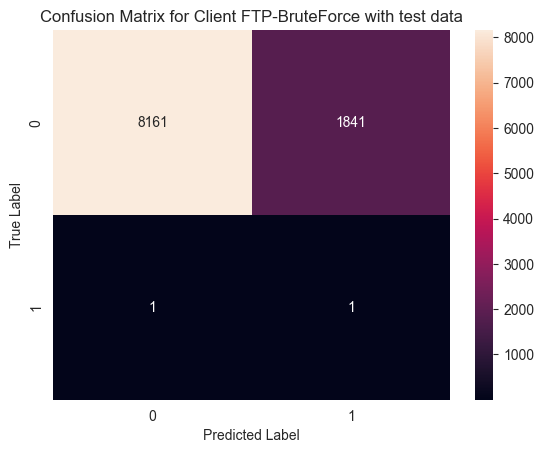

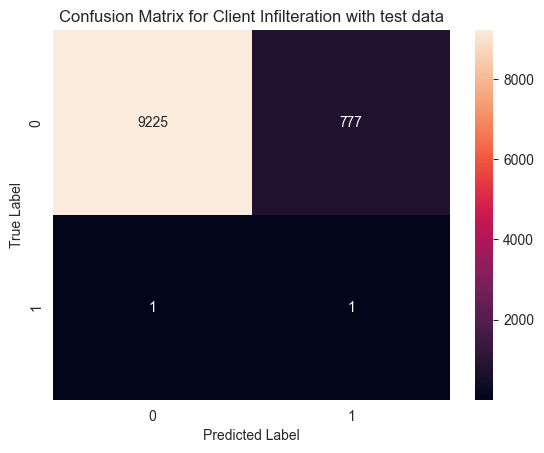

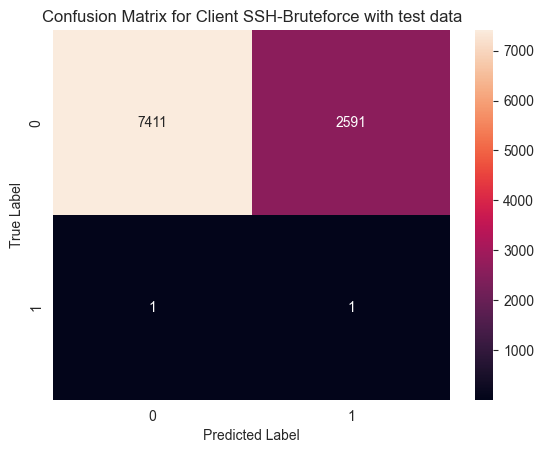

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, rankdata, pearsonr
from sklearn.metrics import mutual_info_score
selectedattackbenmix_stats = []
res=[]
device_idx = {device: i for i, device in enumerate(devices)}
for device in devices:
  model = client_models[device]
  model.eval()
  labels = device
  threshold = thresholds[device]
  temp=[]
  y_true = []
  y_pred = []
  ind = 0
  for data in test_datas[device]:
      data = torch.Tensor(data)
      error = np.sum(np.power(data.detach().numpy() - model(data).detach().numpy(), 2))
      temp.append(error)
      if device == labels:
          y_true.append(1)
          y_pred.append(1 if error < threshold else 0)
      else:
          y_true.append(0)
          y_pred.append(0 if error >= threshold else 1)
      #cf.append([coeff, p, device[:-4] == labels[ind]])
      ind += 1
  res.append([device,min(temp),max(temp)])
  TP, FP, TN, FN = perf_measure(y_true, y_pred)
  TP += 1
  FN += 1
  TN += 1
  FP += 1
  conf_matrix = [[TP, FN], [FP, TN]]
  plt.figure() 
  sns.heatmap(conf_matrix, annot=True, fmt="d")
  plt.title("Confusion Matrix for Client " + str(device) +" with test data")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")

  acc = (TP+TN) / (TP+TN+FP+FN)
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1score = 2 * ((precision * recall) / (precision + recall))

  TPR = round((TP / (TP+FN)), 6)
  # print('TPR is: {}%'.format(TPR))

  FPR = round((FP / (FP + TN)), 6)
  # print('TPR is: {}%'.format(FPR))

  selectedattackbenmix_stats.append([str("Stats for Client " + str(device) +" with test data"),acc*100,precision,recall,F1score*100,TPR,FPR])

  #   [['TP', 'FN']
  #   ['FP', 'TN']]

Plot for global model

In [30]:
# load model
global_model = torch.load('C:/Final Year Project/models/globalattackmodel.pt')                                        

# Testing client models with equal number of all data (selected and not selected)

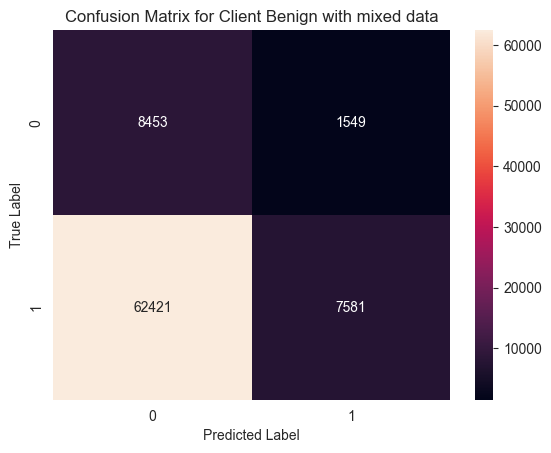

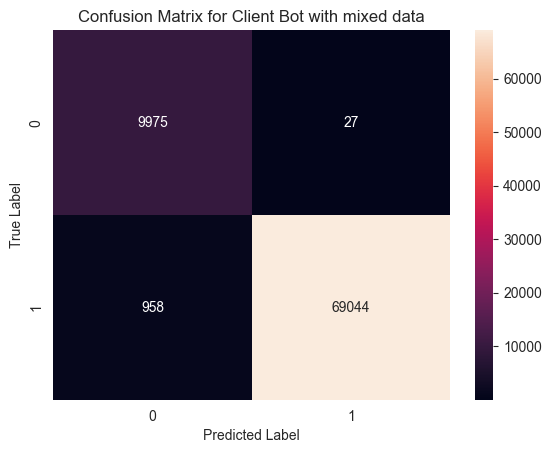

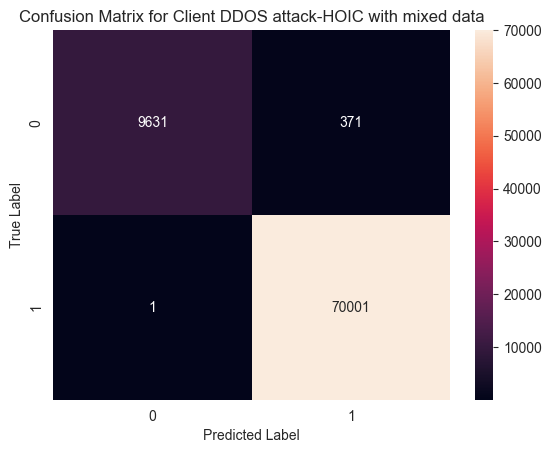

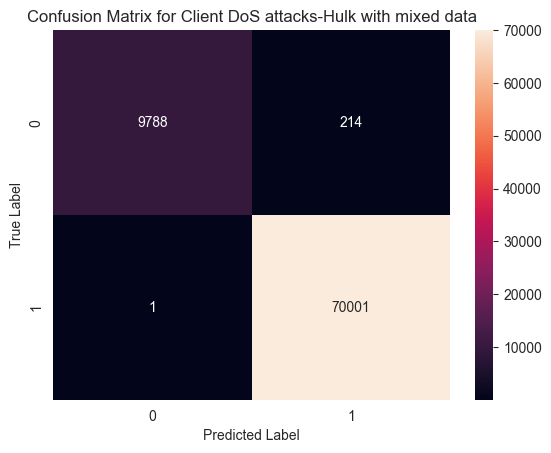

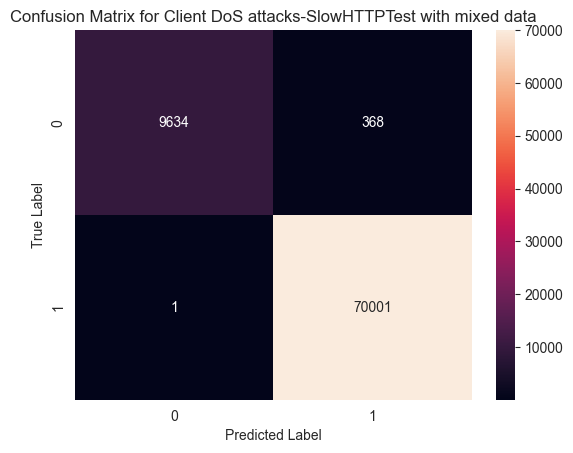

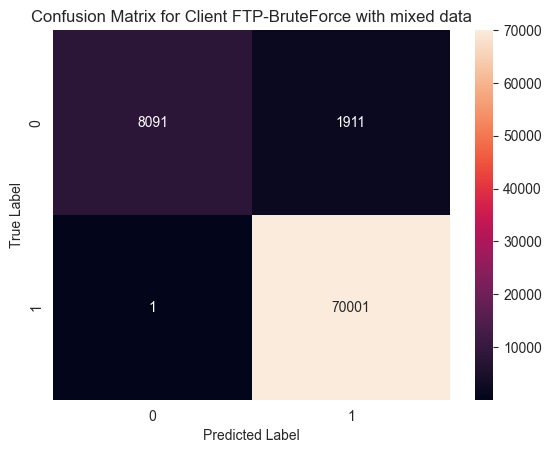

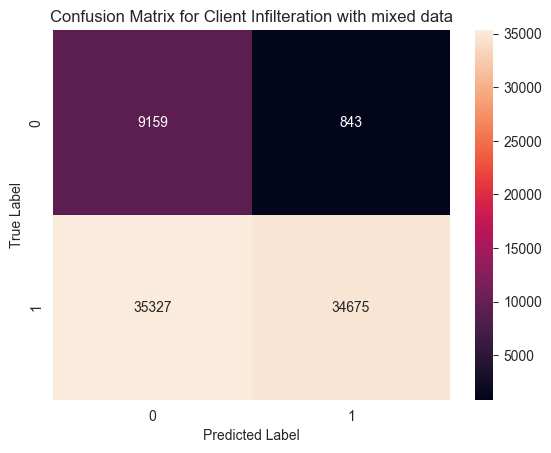

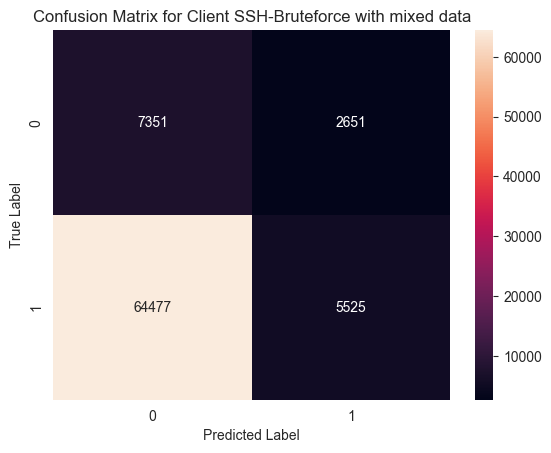

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, rankdata, pearsonr
from sklearn.metrics import mutual_info_score
selectedattackbenmix_stats = []
res=[]
device_idx = {device: i for i, device in enumerate(devices)}
for device in devices:
#  if device == 'Infilteration.csv':
  model = client_models[device]
  model.eval()
  labels = mixed_data_labels
  threshold = thresholds[device]
  temp=[]
  y_true = []
  y_pred = []
  ind = 0
  for data in mixed_data:
      data = torch.Tensor(data)
      error = np.sum(np.power(data.detach().numpy() - model(data).detach().numpy(), 2))
      temp.append(error)
      if device == labels[ind]:
          y_true.append(1)
          y_pred.append(1 if error < threshold else 0)
      else:
          y_true.append(0)
          y_pred.append(0 if error >= threshold else 1)
      #cf.append([coeff, p, device[:-4] == labels[ind]])
      ind += 1
  res.append([device,min(temp),max(temp)])
  TP, FP, TN, FN = perf_measure(y_true, y_pred)
  TP += 1
  FN += 1
  TN += 1
  FP += 1
  conf_matrix = [[TP, FN], [FP, TN]]
  plt.figure() 
  sns.heatmap(conf_matrix, annot=True, fmt="d")
  plt.title("Confusion Matrix for Client " + str(device) +" with mixed data")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")

  acc = (TP+TN) / (TP+TN+FP+FN)
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1score = 2 * ((precision * recall) / (precision + recall))

  TPR = round((TP / (TP+FN)), 6)
  # print('TPR is: {}%'.format(TPR))

  FPR = round((FP / (FP + TN)), 6)
  # print('TPR is: {}%'.format(FPR))

  selectedattackbenmix_stats.append([str("Stats for Client " + str(device) +" with mixed data"),acc*100,precision,recall,F1score*100,TPR,FPR])

  #   [['TP', 'FN']
  #   ['FP', 'TN']]

In [47]:
res

[['Benign', 37.187645, 100.57736],
 ['Bot', 0.00056087994, 20.803823],
 ['DDOS attack-HOIC', 0.00014954964, 19.038502],
 ['DoS attacks-Hulk', 0.0015787624, 11.400023],
 ['DoS attacks-SlowHTTPTest', 0.0033379328, 22.69944],
 ['FTP-BruteForce', 3.375821e-06, 23.176188],
 ['Infilteration', 0.028131578, 13.843772],
 ['SSH-Bruteforce', 0.09111071, 13.579992]]

In [48]:
thresholds

{'Benign': 61.87798387132028,
 'Bot': 0.09161945656969754,
 'DDOS attack-HOIC': 0.02585825799928147,
 'DoS attacks-Hulk': 0.13915533441081115,
 'DoS attacks-SlowHTTPTest': 0.007261200969461877,
 'FTP-BruteForce': 0.0034343920695094742,
 'Infilteration': 0.8323591285998359,
 'SSH-Bruteforce': 2.828172639238413}

In [32]:
for i in selectedattackbenmix_stats:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))

Title: Stats for Client Benign with trained attack dataframe
Accuracy: 20.041497925103748
Precision: 0.11926799672658521
Recall: 0.8451309738052389
F1 score : 20.903605519560813
TPR : 0.845131
FPR : 0.891703
Title: Stats for Client Bot with trained attack dataframe
Accuracy: 98.76881155942203
Precision: 0.9123753772980884
Recall: 0.9973005398920216
F1 score : 95.29496059230952
TPR : 0.997301
FPR : 0.013685
Title: Stats for Client DDOS attack-HOIC with trained attack dataframe
Accuracy: 99.53502324883756
Precision: 0.9998961794019934
Recall: 0.9629074185162967
F1 score : 98.10532749312418
TPR : 0.962907
FPR : 1.4e-05
Title: Stats for Client DoS attacks-Hulk with trained attack dataframe
Accuracy: 99.73126343682816
Precision: 0.9998978445193585
Recall: 0.9786042791441711
F1 score : 98.91364761760396
TPR : 0.978604
FPR : 1.4e-05
Title: Stats for Client DoS attacks-SlowHTTPTest with trained attack dataframe
Accuracy: 99.53877306134693
Precision: 0.9998962117280747
Recall: 0.963207358528294

In [ ]:
import matplotlib
matplotlib.pyplot.close()

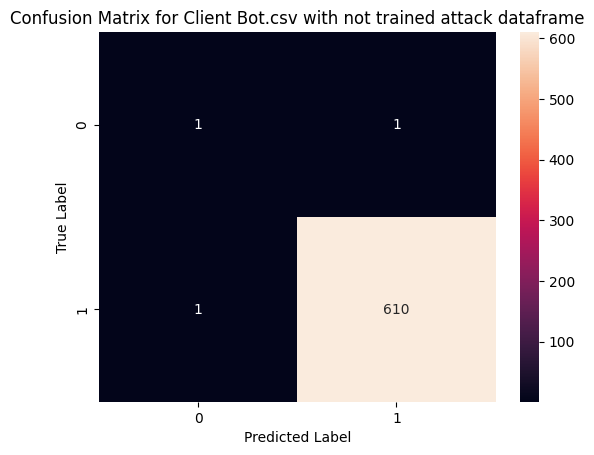

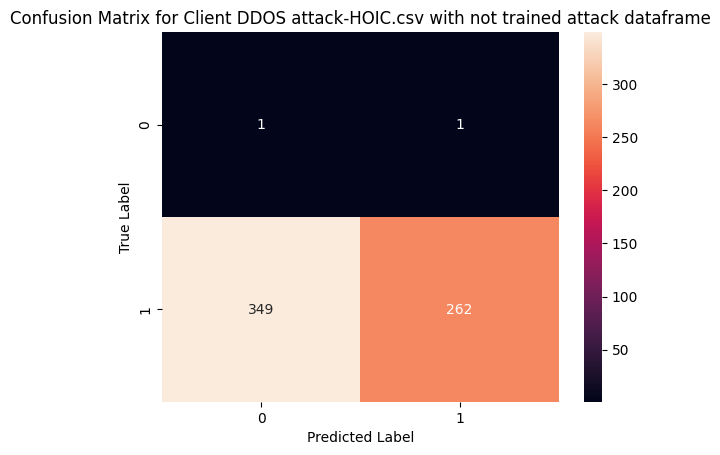

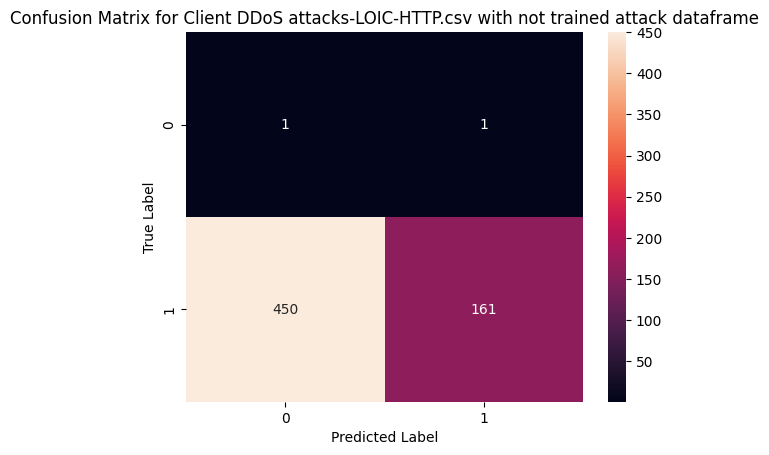

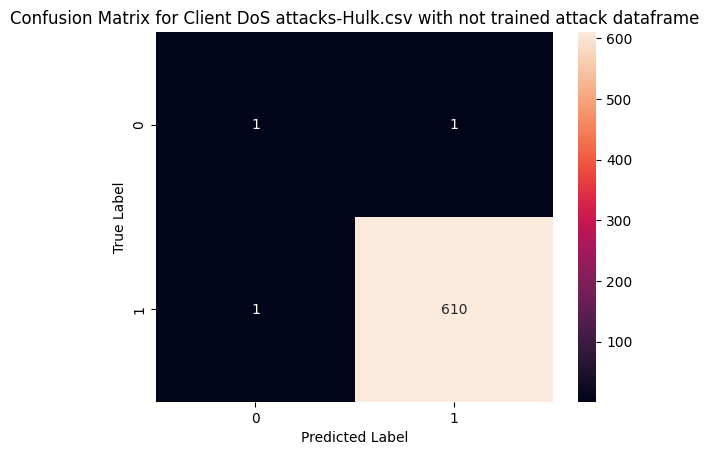

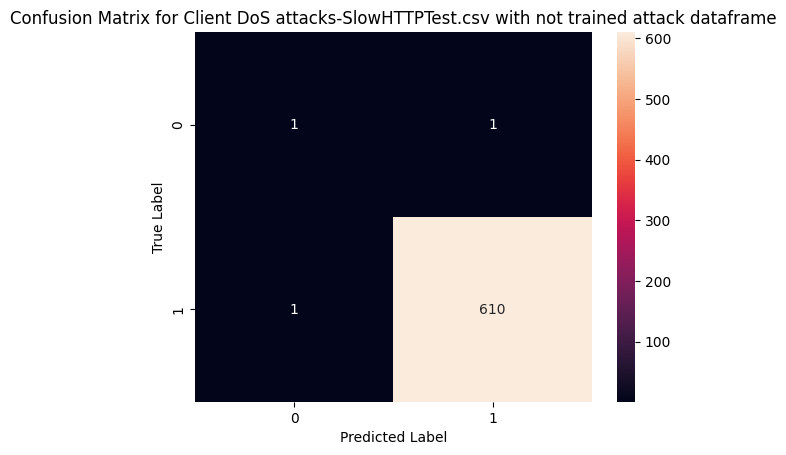

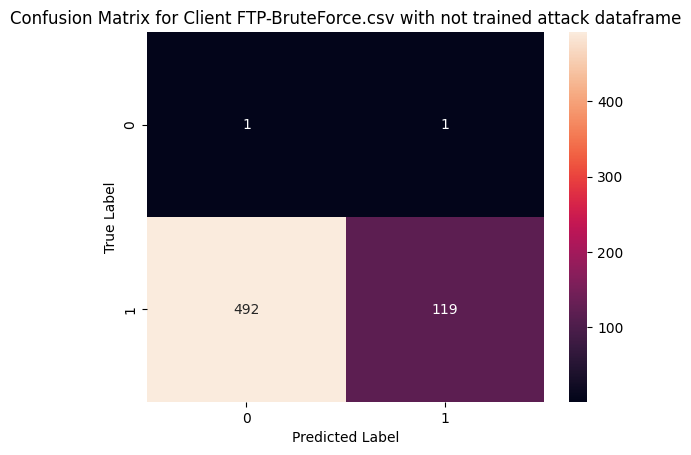

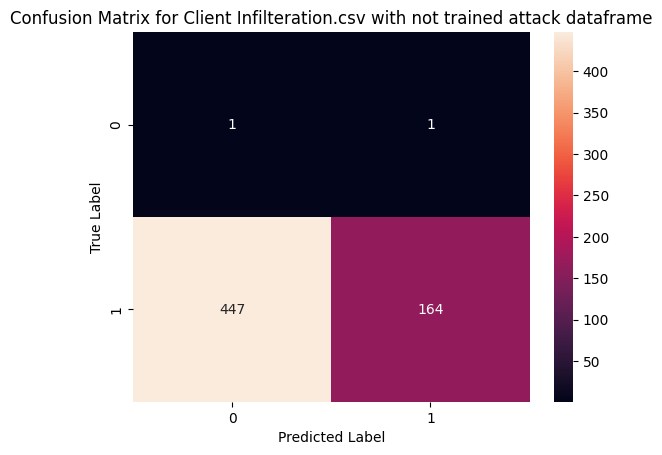

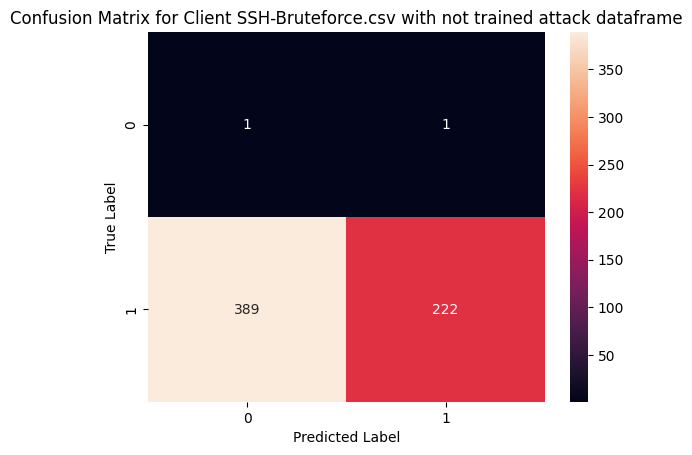

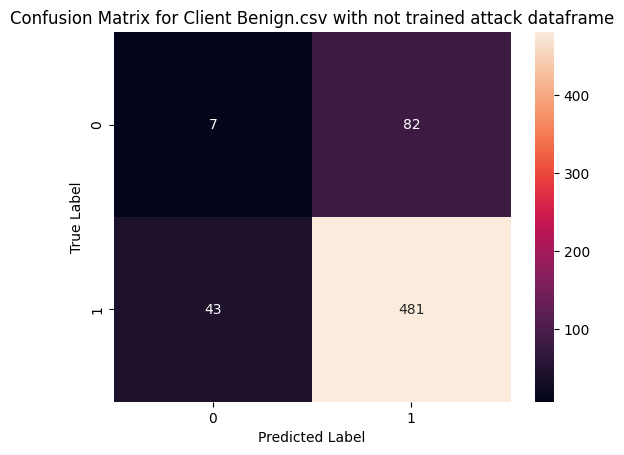

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, rankdata
notselectedattackbenmix_stats = []
device_idx = {device: i for i, device in enumerate(devices)}
for device in devices:
  model = client_models[device_idx[device]]
  model.eval()
  threshold = thresholds[device]
  labels = list(notselectedattackbenmix_labels)
  y_true = []
  y_pred = []
  test_set = notselectedattackbenmix_loader
  ind = 0
  for batch in test_set:
    for data in batch:
      error = np.power(data.float().cpu().numpy() - model(data.float()).cpu().detach().numpy(), 2)
      threshold_ranked = rankdata(threshold)
      error_ranked = rankdata(error)
      coeff, p = spearmanr(threshold_ranked, error_ranked)
      if device[:-4] == labels[ind]:
          y_true.append(1)
          y_pred.append(1 if 0.75 <= coeff else 0)
      else:
          y_true.append(0)
          y_pred.append(0 if 0.75 >= coeff else 1)
      ind += 1
  TP, FP, TN, FN = perf_measure(y_true, y_pred)
  TP += 1
  FN += 1
  TN += 1
  FP += 1
  conf_matrix = [[TP, FN], [FP, TN]]
  plt.figure() 
  sns.heatmap(conf_matrix, annot=True, fmt="d")
  plt.title("Confusion Matrix for Client " + str(device) +" with not trained attack dataframe")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")

  acc = (TP+TN) / (TP+TN+FP+FN)
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1score = 2 * ((precision * recall) / (precision + recall))

  TPR = round((TP / (TP+FN)), 6)
  # print('TPR is: {}%'.format(TPR))

  FPR = round((FP / (FP + TN)), 6)
  # print('TPR is: {}%'.format(FPR))

  notselectedattackbenmix_stats.append([str("Stats for Client " + str(device) +" with not trained attack dataframe"),acc*100,precision,recall,F1score*100,TPR,FPR])

#   [['TP', 'FN']
#   ['FP', 'TN']]

In [ ]:
for i in notselectedattackbenmix_stats:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))

Title: Stats for Client Bot.csv with not trained attack dataframe
Accuracy: 99.673735725938
Precision: 0.5
Recall: 0.5
F1 score : 50.0
TPR : 0.5
FPR : 0.001637
Title: Stats for Client DDOS attack-HOIC.csv with not trained attack dataframe
Accuracy: 42.90375203915171
Precision: 0.002857142857142857
Recall: 0.5
F1 score : 0.5681818181818181
TPR : 0.5
FPR : 0.571195
Title: Stats for Client DDoS attacks-LOIC-HTTP.csv with not trained attack dataframe
Accuracy: 26.42740619902121
Precision: 0.0022172949002217295
Recall: 0.5
F1 score : 0.44150110375275936
TPR : 0.5
FPR : 0.736498
Title: Stats for Client DoS attacks-Hulk.csv with not trained attack dataframe
Accuracy: 99.673735725938
Precision: 0.5
Recall: 0.5
F1 score : 50.0
TPR : 0.5
FPR : 0.001637
Title: Stats for Client DoS attacks-SlowHTTPTest.csv with not trained attack dataframe
Accuracy: 99.673735725938
Precision: 0.5
Recall: 0.5
F1 score : 50.0
TPR : 0.5
FPR : 0.001637
Title: Stats for Client FTP-BruteForce.csv with not trained attack

In [ ]:
import matplotlib
matplotlib.pyplot.close()

# Testing global model with equal number of all data (selected only) (not selected does not have threshold)

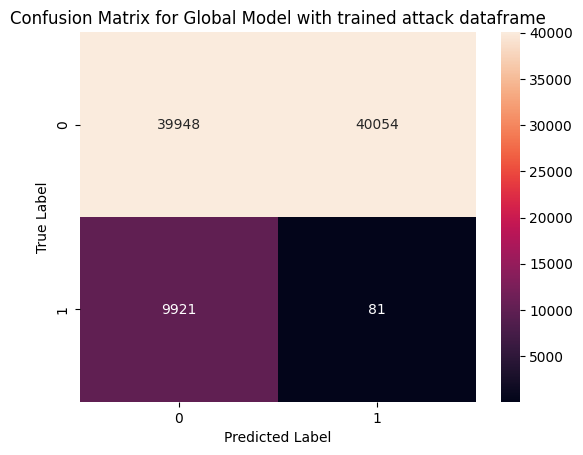

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
selectedattackbenmix_stats_global = []
device_idx = {device: i for i, device in enumerate(devices)}
model = global_model
model.eval()
test_set = selectedattackbenmix_loader
labels = list(selectedattackbenmix_labels)
y_true = []
y_pred = []
ind = 0
for batch in test_set:
    for data in batch:
        pred = model(data.float())
        error = torch.mean((pred.float() - data.float())**2, dim=tuple(range(1,pred.ndim)))
        label = labels[ind]
        threshold = thresholds[label+str('.csv')]
        if label == 'Benign':
            threshold = max(thresholds.values())
            y_true.append(0)
            y_pred.append(0 if error >= threshold else 1)
        else:
            y_true.append(1)
            y_pred.append(1 if error <= threshold else 0)
        ind += 1
TP, FP, TN, FN = perf_measure(y_true, y_pred)
TP += 1
FN += 1
TN += 1
FP += 1
conf_matrix = [[TP, FN], [FP, TN]]
plt.figure() 
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix for Global Model with trained attack dataframe")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

acc = (TP+TN) / (TP+TN+FP+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1score = 2 * ((precision * recall) / (precision + recall))

TPR = round((TP / (TP+FN)), 6)
# print('TPR is: {}%'.format(TPR))

FPR = round((FP / (FP + TN)), 6)
# print('TPR is: {}%'.format(FPR))

selectedattackbenmix_stats_global.append([str("Stats for Globel Model with trained attack dataframe"), acc*100, precision, recall, F1score*100, TPR, FPR])

#   [['TP', 'FN']
#   ['FP', 'TN']]

In [ ]:
for i in selectedattackbenmix_stats_global:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))

Title: Stats for Globel Model with trained attack dataframe
Accuracy: 44.47469001377716
Precision: 0.8010587739878482
Recall: 0.49933751656208597
F1 score : 61.519507819297615
TPR : 0.499338
FPR : 0.991902


In [ ]:
import matplotlib
matplotlib.pyplot.close()